<a href="https://colab.research.google.com/github/CoderSsVartak/Image-Reconstruction/blob/master/image_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Curriculum learning algorithm:
# Train the model on easier dataset
# once satisfactory results are achieved, alter the dataset and merge the dataset with tougher examples
# Consider 12 buckets with mean as 0.1, 0.2..... and variance as 0.1 and 0.5
 
 
# About noise: Increasing the mean makes the image whiter, like effect of flash, it retains the actual shape of the face
#               Increasing the sigmoid, adds noise

# Version 5:
## Bucket 1: white noise, mean = 0.0, variance = 0.01, PSNR = 44.82, randomness added 75s
## Bucket 2: white noise, mean = 0.0, variance = 0.05, PSNR = 31.04, randomness added 169s
## Bucket 3: white noise, mean = 0.0, variance = 0.12, PSNR = 23.71, randomness added 290s
## Bucket 4: white noise, mean = 0.0, variance = 0.35, PSNR = 16.45, randomness added  350s
## Bucket 5: white noise, mean = 0.0, variance = 0.50, PSNR = 14.48, randomness added  490s
## Bucket 6: white noise, mean = 0.0, variance = 0.74, PSNR = 10.74, randomness added 550s
# Bucket 7: white noise, mean = 0.0, variance = 0.95, PSNR = ?, randomness added 
 
# Model v5
    # 120 epochs per training bucket
    # total 8 buckets each having a size of 300 examples
    # Change learning rate and momentum after 50, 90 epochs, lr = [0.01, 0.01, 0.001], and momentum = [0.2, 0.4, 0.6]
    # start lr = 0.01, momentum = 0.2

# Version 6:
## Bucket 1: white noise, mean = 0.0, variance = 0.02, PSNR = 34.06, Percentage Noise = 2% randomness not added 97s per epoch
## Bucket 2: white noise, mean = 0.0, variance = 0.06, PSNR = 24.71, Percentage Noise = 6%, randomness not added 195s per epoch
## Bucket 3: white noise, mean = 0.0, variance = 0.1, PSNR = 20.34, Percentage Noise = 10%, randomness not added 275s per epoch
## Bucket 4: white noise, mean = 0.0, variance = 0.2, PSNR = 15.34, Percentage Noise = 19%, randomness not added 388s per epoch

# Model v6
    # 100 epochs per training bucket
    # lr = [0.01, 0.001], momentum = [0.2, 0.4], epochs=[50, 50]
    # Comment after 4 buckets: Not enough PSNR generated, input higher sigmoid values

# Version 7:
## Bucket 1: white noise, mean = 0.0, variance = 0.05, PSNR = 26.71, Percentage Noise = 5% randomness not added 197s per epoch
## Bucket 2: white noise, mean = 0.0, variance = 0.1, PSNR = 20.06, Percentage Noise = 10%, randomness not added 325s per epoch
## Bucket 3: white noise, mean = 0.0, variance = 0.2, PSNR = 15.71, Percentage Noise = 19%, randomness not added 475s per epoch

# Model v7
    # 100 epochs per training bucket
    # lr = [0.01, 0.001], momentum = [0.4, 0.6], epochs=[50, 50]

    # After completing 3 buckets, model produces blurry results, switch to smaller filter size in further models and add more layers instead

# Version 9
# Bucket 1: white noise, mean = 0.0, variance = 0.01, PSNR = 40.05, Percentage Noise = 1% randomness not added 170s per epoch
# Bucket 2: white noise, mean = 0.0, variance = 0.05, PSNR = 26.71, Percentage Noise = 6%, randomness not added 348s per epoch
# Bucket 3: white noise, mean = 0.0, variance = 0.1, PSNR = 20.59, Percentage Noise = 11%, randomness not added 510s per epoch
# Bucket 4: white noise, mean = 0.0, variance = 0.25, PSNR = 13.07, Percentage Noise = 23%, randomness not added 650s per epoch
# Bucket 5: white noise, mean = 0.0, variance = 0.35, PSNR = 11.02, Percentage Noise = 28%, randomness not added 700s per epoch
# Bucket 6: white noise, mean = 0.0, variance = 0.50, PSNR = 15.34, Percentage Noise = 19%, randomness not added 388s per epoch

# Model v9:
    # Same as that of Version 5 with no randomness and model will have 128 and 64 filters with 120 epochs
    # epoch = [90, 30] with lr = [0.01, 0.001], momentum = [0.2, 0.4]



In [1]:
import os
import time
import random
import datetime
import pytz

#Image manipulation packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

#Tensorflow models libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
#Alternative of pickle for larger files
import joblib
import pickle

#packages required to get the data uploaded on the drive
from googleapiclient.http import MediaIoBaseDownload
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from google.colab import drive
import io
import random

In [2]:
# Google Drive API Code to authenticate access
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#Code to load images from Drive
def load_drive_data(file_id):

    drive_service = build('drive', 'v3')
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()

    downloaded.seek(0)

    # Joblib is used because of large file size
    f = joblib.load(downloaded)

    return f

#images downloaded are in the form of a dictionary, convert it to a numpy array
def dict_to_array(images):

    image_list = []
    for persons in images.keys():
        image_list.append(images[persons])
    
    return np.array(image_list)

#function to plot multiple images
def plot(images, figsize=(10, 10)):

    plt.figure(figsize=figsize)
    
    for index, image in enumerate(images):
        # display original
        ax = plt.subplot(2, len(images), index + 1)
        plt.imshow(image.reshape(image.shape[0], image.shape[1], image.shape[2]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
#images obtained are in the form of a dictionary and have values between 0-1, and are cropped so as to obtain just the facial images
#dictionary[person] = image_value

# Data description: Total facial images of 105 people with each person having a total of 6 images
# Input given is the file id of the file stored in drive
image_data = load_drive_data('1QZv7mWvvF8mnT0A2mA4OFSvxF1eqPd8g')
images = dict_to_array(image_data)

# Create data copy to local storage, can be accessed directly from there
with open('image_data.pickle', 'wb') as file:
    joblib.dump(images, file)

# Load the test set images required
# with open('/content/image_data.pickle', 'rb') as file:
#     images = joblib.load(file)

In [5]:
del (image_data)
images.shape

(630, 224, 224, 3)

In [6]:
#add noise to these facial images
# Algorithm 1, Add White Noise
def add_noise(images, mean=0., sigmoid=0.3, clip=True, return_params=False, add_random=True):
    
    random = np.random.rand(images.shape[0], images.shape[1], images.shape[2], images.shape[3])
    dist = np.random.normal(loc=mean, scale=sigmoid, size=images.shape)
    
    # print(images.shape, random.shape, dist.shape)

    if add_random:
        noise = random * dist
        
        # Memory Management
        del random

        images_noise = images + noise

    else:
        noise = dist
        images_noise = images + dist

    # Memory management
    del dist
    

    if clip:
        images_noise = np.clip(images_noise, 0.0, 1.)
    
    if return_params:
        return images_noise, noise
    
    return images_noise


#Algorithm 2
#First zoom the input image and then regenerate it to create the blur effect
#The blur effect here is because of loss of pixel values during reconstruction
def zoom_blur(images, zoom_size=50, actual_size=224):

    blur_imgs = []
    for img in images:
        blur_imgs.append(cv2.resize(cv2.resize(img, (zoom_size, zoom_size)), (actual_size, actual_size)))
    
    return np.array(blur_imgs)


#find mean value of the 4 dimensional array
def find_mean(images):

    new_images = np.reshape(images, (images.shape[0]*images.shape[1]*images.shape[2]*images.shape[3]))
    return np.abs(np.mean(new_images))

#Find percent of noise in image set : Image set is 4 dimensional
#input is the noisy image and the noise that is added to the image
def find_percent(actual_images, noisy_images):

    # mean |(noisy-actual)/(noisy)| With mean shifting
    return np.mean(np.abs(((noisy_images+np.mean(noisy_images))-(actual_images+np.mean(actual_images)))/(noisy_images+np.mean(noisy_images))))

#Tensorflow function to find psnr of an image
def psnr(y_true, y_pred):

    return tf.math.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1, name=None))

In [ ]:
psnr(images[:10], zoom_blur(images[: 10], zoom_size=100))

<tf.Tensor: shape=(), dtype=float32, numpy=34.4234>

Actual Image


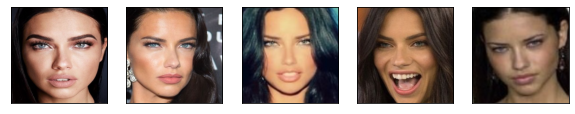

Noisy Image


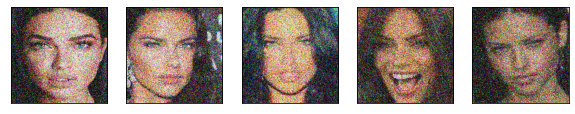

tf.Tensor(11.208245, shape=(), dtype=float32)
Precent: 28.59582275256869


In [ ]:
#Visualizing the effects of blur
print("Actual Image")
plot(images[:5])

print("Noisy Image")

sigmoid = 0.35
randomness_added = False
plot(add_noise(images[:5], mean=0., sigmoid=sigmoid, add_random=randomness_added))
print(psnr(images[: 5], add_noise(images[:5], mean=0., sigmoid=sigmoid, add_random=randomness_added)))
print("Precent:", find_percent(images[:5], add_noise(images[:5], mean=0., sigmoid=sigmoid, add_random=randomness_added))*100)

# print("Zoom Blur")
# plot(zoom_blur(images[:5], zoom_size=75))

In [7]:
#Store different sets of images in each variable and then combine them to make the training dataset

#Do not consider all the images but only a subset for memory reasons
bucket_size = 270
test_bucket_size = 30

start, end = bucket_size, bucket_size + test_bucket_size

# Create the input and output dataset
# first bucket has images from 0 to 300 and 2nd bucket has data from 300 to 600, continue the same for further 
bucket = np.concatenate((add_noise(images[: start], mean=0., sigmoid=0.01, add_random=False), 
                         add_noise(images[: start], mean=0., sigmoid=0.05, add_random=False),
                         add_noise(images[: start], mean=0., sigmoid=0.10, add_random=False),
                         add_noise(images[: start], mean=0., sigmoid=0.25, add_random=False),
                         add_noise(images[: start], mean=0., sigmoid=0.35, add_random=False)))

bucket_op = np.concatenate((images[: start], 
                            images[: start],
                            images[: start],
                            images[: start],
                            images[: start]))

# Test images will be from 270 to 300
test_bucket = np.concatenate((add_noise(images[start: end], mean=0., sigmoid=0.01, add_random=False), 
                              add_noise(images[start: end], mean=0., sigmoid=0.05, add_random=False),
                              add_noise(images[start: end], mean=0., sigmoid=0.10, add_random=False),
                              add_noise(images[start: end], mean=0., sigmoid=0.25, add_random=False),
                              add_noise(images[start: end], mean=0., sigmoid=0.35, add_random=False)))

test_bucket_op = np.concatenate((images[start: end], 
                                 images[start: end],
                                 images[start: end],
                                 images[start: end],
                                 images[start: end]))


# For 1st stage
# bucket = add_noise(images[:bucket_size], mean=0.0, sigmoid=0.01, add_random=False)
# bucket_op = images[: bucket_size]

print("Bucket Filled", bucket.shape, bucket_op.shape)
print()
print("Test Bucket Filled", test_bucket.shape, test_bucket_op.shape)

Bucket Filled (1350, 224, 224, 3) (1350, 224, 224, 3)

Test Bucket Filled (150, 224, 224, 3) (150, 224, 224, 3)


In [8]:
print("Total Step Data")
print(find_percent(bucket_op, bucket)*100)
print(find_percent(test_bucket_op, test_bucket)*100)

Total Step Data
13.255828697356762
12.966896251932319


In [ ]:
print("Total Step Data")
print(psnr(bucket_op, bucket))
print(psnr(test_bucket_op, test_bucket))

Total Step Data
tf.Tensor(22.262672, shape=(), dtype=float32)
tf.Tensor(22.256443, shape=(), dtype=float32)


In [9]:
#Combined these noisy images to make the input images and the actual images as the output images
# bucket = np.concatenate((bucket1, bucket2))
# bucket_op = np.concatenate((images, images))

noisy_images = bucket
clear_images = bucket_op

In [10]:
# gaussian_blur.shape, normal_blur.shape, noisy_images.shape, clear_images.shape
noisy_images.shape, clear_images.shape

((1350, 224, 224, 3), (1350, 224, 224, 3))

In [11]:
#To clear memory
del(bucket)
del(bucket_op)

# To reload the images array, use the image_data.pickle file stored in the content folder
del (images)

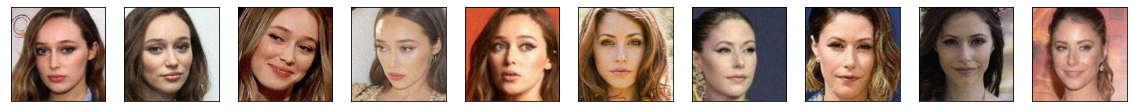

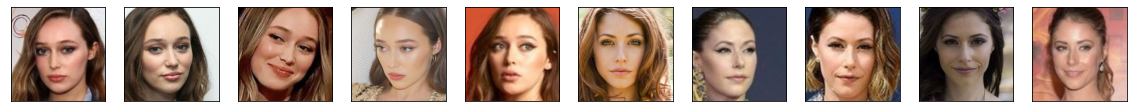

tf.Tensor(28.931602, shape=(), dtype=float32)


In [ ]:
plot(noisy_images[295: 305], figsize=(20,20))
plot(clear_images[295: 305], figsize=(20,20))
print(psnr(clear_images, noisy_images))

In [12]:
# Version 5 and 6 network architecture:
def create_model_prev():

    input_img = Input(shape=(224, 224, 3), dtype='float32')
    
    #1st Convolution Layer with Batch Normalization
    x = Conv2D(64, (9, 9), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    
    #2nd Convolution Layer without Batch Normalization
    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    
    #3rd Conv Layer
    x = Conv2D(3, (5, 5), activation='relu', padding='same')(x)
    
    model = Model(input_img, x)
    
    return model

# Version 9 network architecture
def create_model():

    input_img = Input(shape=(224, 224, 3), dtype='float32')
    
    #1st Convolution Layer with Batch Normalization
    x = Conv2D(128, (9, 9), activation='relu', padding='same')(input_img)
    
    #2nd Convolution Layer without Batch Normalization
    x = Conv2D(64, (1, 1), activation='relu', padding='same')(x)
    
    #3rd Conv Layer
    x = Conv2D(3, (5, 5), activation='relu', padding='same')(x)
    
    model = Model(input_img, x)
    
    return model

In [13]:
model = create_model()

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 128)     31232     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      8256      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 3)       4803      
Total params: 44,291
Trainable params: 44,291
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_path = '/Image_Denoising_v9.4_Bucket5_60epochs.h5'
model.load_weights(model_path)

In [16]:
# Training Phase: input = train_noisy, output = train_clear
#Test Phase: input = test_noisy, output = test_clear
train_noisy, test_noisy, train_clear, test_clear = noisy_images, test_bucket, clear_images, test_bucket_op

In [17]:
# To save ram
del(noisy_images)
del(clear_images)
del(test_bucket)
del(test_bucket_op)

In [18]:
# Dataset Statistics
print(find_percent(test_clear, test_noisy), find_percent(train_clear, train_noisy))

0.1296689625193232 0.1325582869735676


In [ ]:
print(find_mean(test_noisy), find_mean(train_noisy))

0.4381383288737269 0.4278642187617188


In [ ]:
print(psnr(test_clear, test_noisy), psnr(train_clear, train_noisy))

tf.Tensor(22.256443, shape=(), dtype=float32) tf.Tensor(22.262672, shape=(), dtype=float32)


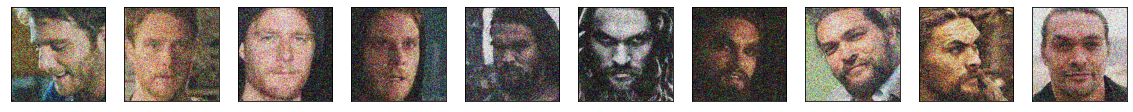

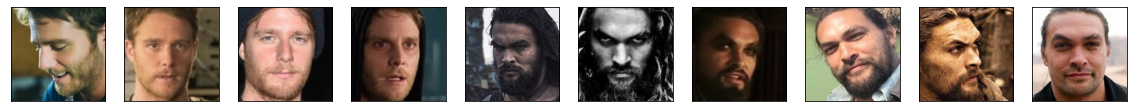

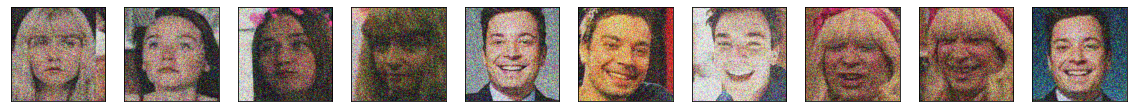

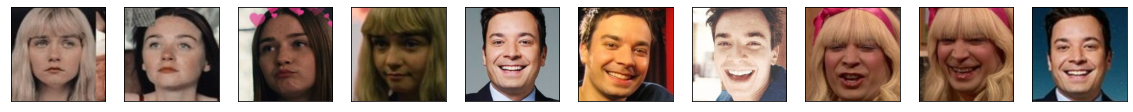

(1350, 224, 224, 3) (150, 224, 224, 3)


In [ ]:
plot(train_noisy[1340:1350], figsize=(20, 20))
plot(train_clear[1340:1350], figsize=(20, 20))
plot(test_noisy[140:150], figsize=(20, 20))
plot(test_clear[140:150], figsize=(20, 20))

print(train_noisy.shape, test_noisy.shape)

In [19]:
def cosine_dist(y_true, y_pred):
    return tf.reduce_mean(tf.abs(tf.losses.cosine_similarity(y_true, y_pred)))

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.losses.mean_squared_error(y_true, y_pred))

def model_loss(y_true, y_pred):
    return tf.reduce_mean(tf.losses.mean_squared_error(y_true, y_pred) + (1 - cosine_dist(y_true, y_pred)))

In [20]:
# Dataset Statistics
print(mse(test_clear, test_noisy), mse(train_clear, train_noisy))

tf.Tensor(0.027109441339346736, shape=(), dtype=float64) tf.Tensor(0.02689798949369012, shape=(), dtype=float64)


In [21]:
# Code to save logs

# Model is the tensorflow/keras model
# history is the dictionary returned after model training
# logs are stored as a dictionary with key as the model_name, date and time
# Buket number is string
def save(model=None, history=None, name="Image_Denoising_v4.1.h5", bucket_num=None, logs=None, logfile_name=None, save_logs=False, print_feedback=False):

    # Selected the timezone to save logs according to IST
    tz = pytz.timezone("Asia/Kolkata")

    if model and name:
        model.save(name)
        if print_feedback:
            print("Model Saved")

    elif model:
        model.save("Image_Denoising.h5")
        if print_feedback:
            print("Model Saved")
    
    if history:
        logs[f'Bucket{bucket_num}_logs_{datetime.datetime.now(tz)}'] = history.history
        if print_feedback:
            print("History Saved in logs")

    if save_logs:
        with open(logfile_name, 'ab') as file:
            pickle.dump({'logs': logs}, file)
        if print_feedback:
            print("Logs Saved and are ready to be downloaded")
    return True

#Load the logfile
def load(model=None, model_name=None, logfile_name=None):

    if model and model_name:
        model.load(model_name)
        print("model loaded")
    if logfile_name:
        with open(logfile_name, 'rb') as file:
            temp_logs = pickle.load(file)

        print("Log file loaded in the form of a dictionary")

        return temp_logs['logs']

    return True

# Training and validation data are tuples where (input, output)
# save_after gives the number of epochs after which the data is to be saved
# Compile the model before passing in as a parameter
def train_model(model, training_data, validation_data, epochs, batch_size, save_after=10, logs=None, model_name=None, bucket_num=None, epochs_done=0):

    # x_input, y_input = training_data[0], training_data[1]

    # Selected the timezone to save logs according to IST
    tz = pytz.timezone("Asia/Kolkata")

    # train model for epochs = save_after, for epochs//save_after amount of time.
    # To track the number of iterations done
    count = 0

    # If all this data is provided only then save the model, else train it normally but dont save it
    if save_after:

        for _ in range(epochs//save_after):

            history = model.fit(training_data[0], training_data[1], validation_data=validation_data, epochs = save_after, batch_size=batch_size)

            # Save the model and the history object
            save(model=model, history=history, name=f'{model_name}_Bucket{bucket_num}_{(count+1)*save_after+epochs_done}epochs.h5', 
                 bucket_num=bucket_num, logs=logs, logfile_name=f'logfile_{datetime.datetime.now(tz)}.pickle', save_logs=True)
            
            # To clear memory
            del history

            print(f'\nModel Saved after: {(count+1)*save_after+epochs_done} epochs')
            # print(f'Keys in logfile: {logs.keys()}\n')

            count += 1
        
        if count*save_after < epochs:

            history = model.fit(training_data[0], training_data[1], validation_data=validation_data, epochs = epochs-count*save_after, batch_size=batch_size)

            # Save the model and the history object
            save(model=model, history=history, name=f'{model_name}_Bucket{bucket_num}_{epochs+epochs_done}epochs.h5',
                 bucket_num=bucket_num, logs=logs, logfile_name=f'logfile_{datetime.datetime.now(tz)}.pickle', save_logs=True)

            # To clear memory
            del history


            print(f'\nModel Saved after: {epochs+epochs_done} epochs')
            # print(f'Keys in logfile: {logs.keys()}\n')

    else:
        history = model.fit(training_data[0], training_data[1], validation_data=validation_data, epochs = epochs, batch_size=batch_size)
        return history

    return True    


In [22]:
# to load logfile
logs = {}
logs = load(logfile_name='/logfile_2021-01-14 22_47_19.341113+05_30.pickle')
print(len(logs.keys()))

# print(len(load(logfile_name='/logfile_2020-12-18 15_09_59.485158+05_30.pickle').keys()))

Log file loaded in the form of a dictionary
17


In [26]:
# Optimizer used: Stochastic Gradient Descent
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.001, momentum=0.4, nesterov=False, name="SGD"
)

# Loss = mse + cosine, metric = psnr
loss = model_loss
metrics = [psnr, mse]

# Epoch to be done, save after how many epochs and how many epochs are done previously in the bucket: max = 120
epochs = 30
save_after = 30
epochs_done = 90

batch_size = 64
bucket_num = 5
model_version = 9
model_name = f'Image_Denoising_v{model_version}.{bucket_num-1}'

In [27]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [28]:
# history = model.fit(train_noisy, train_clear, validation_data=(test_noisy, test_clear), epochs=epochs, batch_size=batch_size)
train_model(model, (train_noisy, train_clear), validation_data=(test_noisy, test_clear), epochs=epochs, batch_size=batch_size,
            save_after=save_after, logs=logs, model_name=model_name, bucket_num=bucket_num, epochs_done=epochs_done)

Epoch 1/30
22/22 [==============================] - 135s 6s/step - loss: 0.0088 - psnr: 27.8819 - mse: 0.0024 - val_loss: 0.0098 - val_psnr: 27.0402 - val_mse: 0.0030
Epoch 2/30
22/22 [==============================] - 132s 6s/step - loss: 0.0086 - psnr: 27.8447 - mse: 0.0024 - val_loss: 0.0098 - val_psnr: 27.0352 - val_mse: 0.0030
Epoch 3/30
22/22 [==============================] - 133s 6s/step - loss: 0.0081 - psnr: 27.8301 - mse: 0.0024 - val_loss: 0.0099 - val_psnr: 27.0403 - val_mse: 0.0030
Epoch 4/30
22/22 [==============================] - 133s 6s/step - loss: 0.0094 - psnr: 27.5320 - mse: 0.0025 - val_loss: 0.0099 - val_psnr: 27.0553 - val_mse: 0.0030
Epoch 5/30
22/22 [==============================] - 133s 6s/step - loss: 0.0083 - psnr: 27.9116 - mse: 0.0024 - val_loss: 0.0099 - val_psnr: 27.0125 - val_mse: 0.0030
Epoch 6/30
22/22 [==============================] - 133s 6s/step - loss: 0.0087 - psnr: 27.7170 - mse: 0.0024 - val_loss: 0.0098 - val_psnr: 27.0293 - val_mse: 0.003

True

In [ ]:
# after the model is trained save the model and the log file
# save(model=model, history=history, name='Image_Denoising_v4.3.h5', bucket_num="4", logs=logs, save_logs=True)
# print("Saved keys are ", logs.keys())

In [37]:
prev_model = create_model_prev()
prev_model.load_weights('/Image_Denoising_v5.5_Bucket6_120epochs.h5')

In [32]:
# Load the test set images required
with open('/content/image_data.pickle', 'rb') as file:
    validate_images = joblib.load(file)[500: 530]

18
Input Images


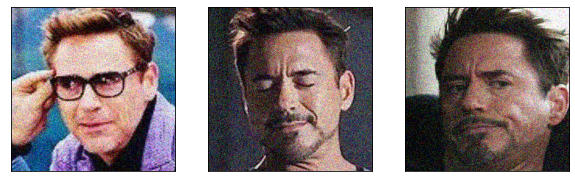

Model's Output


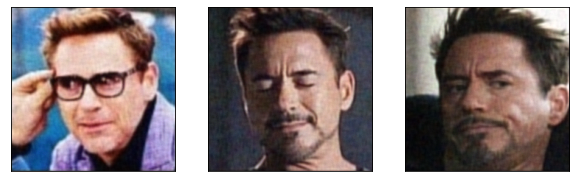


Actual Clear Image


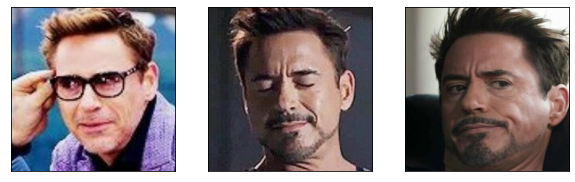

Previous Model's Output


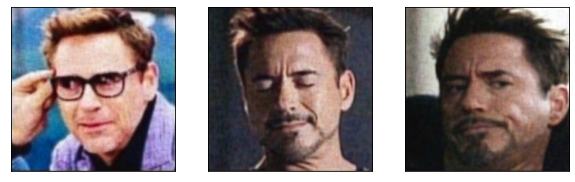

PSNR: 27.87700843811035
Noisy Image PSNR: 19.64670753479004
Previous Model PSNR: 27.13751220703125

Cosine Distance from actual image: 0.9951110482215881
Cosine Distance from Noisy Image: 0.9262564778327942
Cosine Distance of prev prediction: 0.9946625232696533

Mean of Noisy Images: 0.3955502212047577
Mean of Predicted Images: 0.39624202251434326
Mean of Actual Images: 0.3925897181034088
Mean of Previous Pred images: 0.3916204869747162

Mean error noisy image: 0.01084962673485279
Mean error pred image: 0.0016830706736072898
Mean Error of previous prediction: 0.0019863236229866743

Percentage of Noise:  11.579200625419617 %
Percentage of Noise in prediction:  3.811885416507721 %
Percentage of Noise in prev prediction:  4.431580007076263 %

Noisy Image Variance: 0.07711724191904068
Predicted Image Variance: 0.06995823979377747
Prev Predicted Image Variance: 0.07136838883161545


In [47]:
 #Visualize the models predictions and also the time constraints
count = 3
figsize = (10, 10)

#Input & Output Images

# Easier/ Same level as training
# Same distribution as training phase
# start = random.randint(0, test_noisy.shape[0])
# ip_imgs = test_noisy[start: start+count]
# actual_imgs = test_clear[start: start+count]

#Tougher images
# Using clear images to generate noisy images, same process as the one used to generate training images
# Previously unseen dataset
start = random.randint(0, 27)
ip_imgs, noise = add_noise(validate_images[start: start+count], mean=0., sigmoid=0.11, return_params=True, add_random=False)
actual_imgs = validate_images[start: start+count]



# make prediction on a noisy image, generate an output and plot it
# 2nd line of code to compare with previous model

pred_img = model.predict(ip_imgs)
prev_pred_img = prev_model.predict(ip_imgs)


# Converted the datatype to float32 for cosine_dist function to work: required
actual_imgs = actual_imgs.astype('float32')
ip_imgs = ip_imgs.astype('float32')
pred_img = pred_img.astype('float32')

# Plot input images
print(start)
print("Input Images")
plot(ip_imgs, figsize=figsize)

# Plot predicted images
print("Model's Output")
plot(pred_img, figsize=figsize)

# Plot actual images
print("\nActual Clear Image")
plot(actual_imgs, figsize=figsize)

# Plot Previous predicted images
print("Previous Model's Output")
plot(prev_pred_img, figsize=figsize)



#Print metrics
print(f'PSNR: {psnr(actual_imgs, pred_img)}\nNoisy Image PSNR: {psnr(actual_imgs, ip_imgs)}\nPrevious Model PSNR: {psnr(actual_imgs, prev_pred_img)}')
print(f'\nCosine Distance from actual image: {cosine_dist(actual_imgs, pred_img)}\nCosine Distance from Noisy Image: {cosine_dist(actual_imgs, ip_imgs)}\nCosine Distance of prev prediction: {cosine_dist(actual_imgs, prev_pred_img)}')
print(f'\nMean of Noisy Images: {find_mean(ip_imgs)}\nMean of Predicted Images: {find_mean(pred_img)}\nMean of Actual Images: {find_mean(actual_imgs)}\nMean of Previous Pred images: {find_mean(prev_pred_img)}')
print(f'\nMean error noisy image: {mse(actual_imgs, ip_imgs)}\nMean error pred image: {mse(actual_imgs, pred_img)}\nMean Error of previous prediction: {mse(actual_imgs, prev_pred_img)}')
print("\nPercentage of Noise: ", find_percent(actual_imgs, ip_imgs)*100, "%")
print("Percentage of Noise in prediction: ", find_percent(actual_imgs, pred_img)*100, "%")
print("Percentage of Noise in prev prediction: ", find_percent(actual_imgs, prev_pred_img)*100, "%")
print(f'\nNoisy Image Variance: {np.var(ip_imgs)}\nPredicted Image Variance: {np.var(pred_img)}\nPrev Predicted Image Variance: {np.var(prev_pred_img)}')

In [ ]:
def get_bucket_data(bucket_num, logs=None, get_loss=False, get_psnr=False, get_mse=False):

    train_temp, test_temp = [], []
    for key in logs.keys():
        if f'Bucket{bucket_num}' in key:
            if get_loss:
                metric = 'loss'

            if get_psnr:
                metric = 'psnr'
            
            if get_mse:
                metric = 'mse'

            for index in range(len(logs[key][metric])):
                train_temp.append(logs[key][metric][index])
                test_temp.append(logs[key][f'val_{metric}'][index])
            
    return train_temp, test_temp


def plot_curve(train_data=None, validation_data=None, name='', xlabel='', ylabel=''):

    if train_data:
        plt.plot(train_data, label=f'Training {name}')
    
    if validation_data:
        plt.plot(validation_data, label=f'Validation {name}')

    if xlabel:
        plt.xlabel(xlabel)
    
    if ylabel:
        plt.ylabel(ylabel)
    
    if name:
        plt.legend()

    plt.show()    

In [ ]:
# To extract particular log from the log dictionary

# print("Available Keys => ", logs.keys())
# key_name = input("Enter key name: ")
# new_history = logs[key_name]
# train_loss, test_loss = new_history['loss'], new_history['val_loss']
# train_psnr, test_psnr = new_history['psnr'], new_history['val_psnr']


# If logs are not downloaded from the logfile, then run this line of code

# new_history = history.history
# train_loss, test_loss = new_history['loss'], new_history['val_loss']
# train_psnr, test_psnr = new_history['psnr'], new_history['val_psnr']


# If logs are to be merged before plotting
train_loss, test_loss = get_bucket_data(bucket_num=bucket_num, logs=logs, get_loss=True)
train_psnr, test_psnr = get_bucket_data(bucket_num=bucket_num, logs=logs, get_psnr=True)

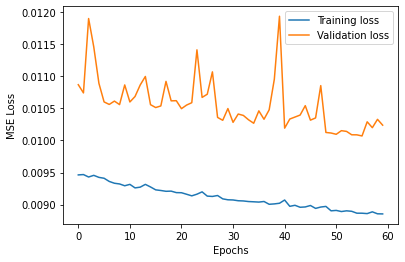

In [ ]:
plot_curve(train_data = train_loss, validation_data = test_loss, name = 'loss', xlabel='Epochs', ylabel = 'MSE Loss')

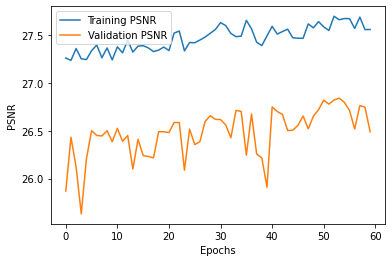

In [ ]:
plot_curve(train_data = train_psnr, validation_data = test_psnr, name = 'PSNR', xlabel='Epochs', ylabel = 'PSNR')

In [ ]:
sim_model = VGG19(include_top=False, weights='imagenet')

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
tf.reduce_sum(sim_model.predict(pred_img)), tf.reduce_sum(sim_model.predict(ip_imgs)), tf.reduce_sum(sim_model.predict(actual_imgs))

(<tf.Tensor: shape=(), dtype=float32, numpy=10745.307>,
 <tf.Tensor: shape=(), dtype=float32, numpy=11021.736>,
 <tf.Tensor: shape=(), dtype=float32, numpy=14179.794>)

In [ ]:
cosine_dist(sim_model.predict(actual_imgs), sim_model.predict(pred_img)), cosine_dist(sim_model.predict(actual_imgs), sim_model.predict(ip_imgs)), cosine_dist(sim_model.predict(actual_imgs), sim_model.predict(actual_imgs))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.97461945>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.99542254>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [ ]:
mse(255*actual_imgs, 255*pred_img), mse(255*actual_imgs, 255*ip_imgs)

(<tf.Tensor: shape=(), dtype=float32, numpy=1853.8549>,
 <tf.Tensor: shape=(), dtype=float32, numpy=11424.814>)

16.050735264247752 %

Noisy Image: 16.77187156677246, 0.021028711811504334
Median Filtering: 26.709003448486328, 0.002133533824235201
Gaussian Filtering: 25.00290298461914, 0.0031601639930158854


Model Prediction: 28.99227523803711, 0.0012611666461452842
Prev Model Prediction: 27.9161434173584, 0.0016157921636477113

	Actual			 Noisy			 Median			   Gaussian		  Model		    Previous Model


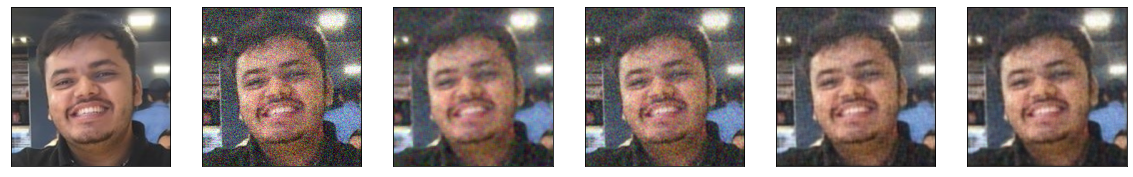

In [50]:
test_img = cv2.imread('/profile_pic.jpg')
test_img = cv2.cvtColor(cv2.resize(test_img, (224, 224)), cv2.COLOR_BGR2RGB)
test_img = np.reshape(test_img/255, (1, 224, 224, 3))
test_blur = add_noise(np.array(test_img), mean=0., sigmoid=0.15, add_random=False)

new_img = np.reshape(test_blur.astype('float32'), (224, 224, 3))
median = cv2.medianBlur(new_img, 5)
gauss = cv2.GaussianBlur(new_img, (3, 3), 0)
model_pred = model.predict(test_blur)
prev_model_pred = prev_model.predict(test_blur)

print(find_percent(test_img, test_blur)*100, "%")

print(f'\nNoisy Image: {psnr(test_img, test_blur)}, {mse(test_img, test_blur)}')
print(f'Median Filtering: {psnr(test_img, median)}, {mse(test_img, median)}')
print(f'Gaussian Filtering: {psnr(test_img, gauss)}, {mse(test_img, gauss)}')
print(f'Model Prediction: {psnr(test_img, model_pred)}, {mse(test_img, model_pred)}')
print(f'Prev Model Prediction: {psnr(test_img, prev_model_pred)}, {mse(test_img, prev_model_pred)}')


# print(f'\nNoisy Image Similarity: {cosine_dist(sim_model.predict(test_img), sim_model.predict(test_blur))}')
# print(f'Model Similarity: {cosine_dist(sim_model.predict(test_img), sim_model.predict(model_pred))}')
# print(f'Median Filtering Similarity: {cosine_dist(sim_model.predict(test_img), sim_model.predict(np.reshape(median, (1, 224, 224, 3))))}')
# print(f'Gaussian Similarity: {cosine_dist(sim_model.predict(test_img), sim_model.predict(np.reshape(gauss, (1, 224, 224, 3))))}')

print()
print("\tActual\t\t\t Noisy\t\t\t Median\t\t\t   Gaussian\t\t  Model\t\t    Previous Model")
plot([test_img[0], test_blur[0], median, gauss, model_pred[0], prev_model_pred[0]], figsize=(20, 20))

In [ ]:
(tf.reduce_sum(sim_model.predict(np.reshape(test_img, (1, 224, 224, 3)))), 
 tf.reduce_sum(sim_model.predict(model_pred)), 
 tf.reduce_sum(sim_model.predict(np.reshape(median, (1, 224, 224, 3))))
)

(<tf.Tensor: shape=(), dtype=float32, numpy=4663.1035>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4773.061>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4819.7383>)

In [ ]:
print(psnr(images[600: 630], model.predict(add_noise(images[600: 630], mean=0., sigmoid=0.25))))

tf.Tensor(25.60634, shape=(), dtype=float32)


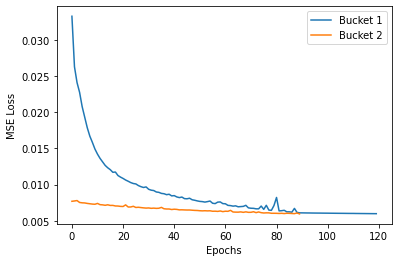

In [ ]:
plt.plot(get_bucket_data(bucket_num=, logs=logs, get_loss=True)[0], label="Bucket 1")
plt.plot(get_bucket_data(bucket_num=bucket_num, logs=logs, get_loss=True)[0], label='Bucket 2')

# plt.plot(get_bucket_data(bucket_num=2, logs=logs, get_loss=True)[0], label='Bucket 2')
# plt.plot(get_bucket_data(bucket_num=3, logs=logs, get_loss=True)[0], label="Bucket 3")
# plt.plot(get_bucket_data(bucket_num=4, logs=logs, get_loss=True)[0], label="Bucket 4")

plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

Log file loaded in the form of a dictionary


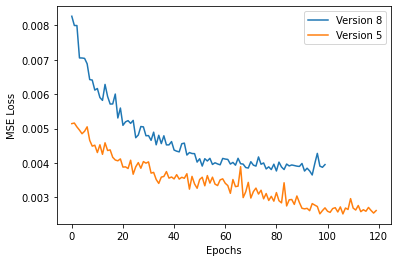

In [ ]:
plt.plot(get_bucket_data(bucket_num=bucket_num, logs=logs, get_mse=True)[0], label="Version 8")
plt.plot(get_bucket_data(bucket_num=bucket_num, logs=load(logfile_name='/logfile_2020-12-25 02_23_41.865580+05_30.pickle'), get_mse=True)[0], label='Version 5')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

Log file loaded in the form of a dictionary


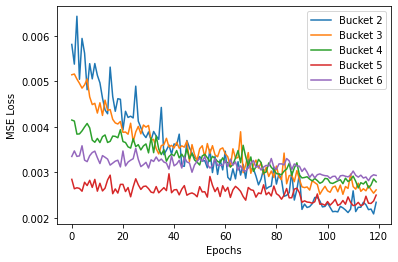

In [ ]:
# Best Model to date: Version 9
version_5_logs = load(logfile_name='/logfile_2021-01-10 23_48_22.747055+05_30.pickle')
# print(version_5_logs.keys())

# plt.plot(get_bucket_data(bucket_num=1, logs=version_5_logs, get_loss=True)[0], label="Bucket 1")
plt.plot(get_bucket_data(bucket_num=2, logs=version_5_logs, get_loss=True)[0], label="Bucket 2")
plt.plot(get_bucket_data(bucket_num=3, logs=version_5_logs, get_loss=True)[0], label="Bucket 3")
plt.plot(get_bucket_data(bucket_num=4, logs=version_5_logs, get_loss=True)[0], label="Bucket 4")
plt.plot(get_bucket_data(bucket_num=5, logs=version_5_logs, get_loss=True)[0], label="Bucket 5")
plt.plot(get_bucket_data(bucket_num=6, logs=version_5_logs, get_loss=True)[0], label="Bucket 6")

plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

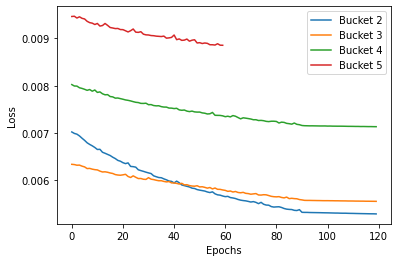

In [ ]:
# Best Model to date: Version 9
version_9_logs = logs
# print(version_5_logs.keys())

# plt.plot(get_bucket_data(bucket_num=1, logs=version_9_logs, get_loss=True)[0], label="Bucket 1")
plt.plot(get_bucket_data(bucket_num=2, logs=version_9_logs, get_loss=True)[0], label="Bucket 2")
plt.plot(get_bucket_data(bucket_num=3, logs=version_9_logs, get_loss=True)[0], label="Bucket 3")
plt.plot(get_bucket_data(bucket_num=4, logs=version_9_logs, get_loss=True)[0], label="Bucket 4")
plt.plot(get_bucket_data(bucket_num=5, logs=version_9_logs, get_loss=True)[0], label="Bucket 5")
# plt.plot(get_bucket_data(bucket_num=6, logs=version_9_logs, get_loss=True)[0], label="Bucket 6")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

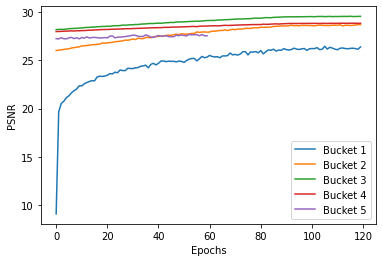

In [ ]:
# Best Model to date: Version 9
version_9_logs = logs
# print(version_5_logs.keys())

plt.plot(get_bucket_data(bucket_num=1, logs=version_9_logs, get_psnr=True)[0], label="Bucket 1")
plt.plot(get_bucket_data(bucket_num=2, logs=version_9_logs, get_psnr=True)[0], label="Bucket 2")
plt.plot(get_bucket_data(bucket_num=3, logs=version_9_logs, get_psnr=True)[0], label="Bucket 3")
plt.plot(get_bucket_data(bucket_num=4, logs=version_9_logs, get_psnr=True)[0], label="Bucket 4")
plt.plot(get_bucket_data(bucket_num=5, logs=version_9_logs, get_psnr=True)[0], label="Bucket 5")
# plt.plot(get_bucket_data(bucket_num=6, logs=version_9_logs, get_psnr=True)[0], label="Bucket 6")

plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.legend()
plt.show()